In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
import scipy.stats as stats
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [3]:
#uploading the data 
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

Here I'm splitting the data before any imputation and feature engineering in order to make sure that the model 
doesn't overfit.

**Overfitting** - A situation where the model perform well on train data but could not perform well on unseen or test data.

If we dont splitting the data before any imputation they may lead to likeage of data which will cause the overfitting

In [4]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(train, train["SalePrice"], test_size=0.3, random_state=42)
X_train.shape , X_test.shape 

((1022, 81), (438, 81))

# Dealing with Missing Values
## Categorical Variable
### String type

In [6]:
# creating a list of all the categorical string type variable having missing values
cat_var_na = []

for label, content in X_train.items():
    if pd.api.types.is_string_dtype(content) and train[label].isnull().sum()*100/ len(X_train)>0:
        cat_var_na.append(label)
        
#checking the missing variable % of missing values
X_train[cat_var_na].isnull().sum()*100/len(X_train)

Alley           93.542074
MasVnrType       0.293542
BsmtQual         2.544031
BsmtCond         2.544031
BsmtExposure     2.544031
BsmtFinType1     2.544031
BsmtFinType2     2.544031
Electrical       0.097847
FireplaceQu     47.651663
GarageType       5.283757
GarageFinish     5.283757
GarageQual       5.283757
GarageCond       5.283757
PoolQC          99.510763
Fence           80.234834
MiscFeature     96.086106
dtype: float64

In [7]:
#divding the list into two sub list

#1st list containing all the variable having  more than 5% of missing values
cat_var_40 = []

#2nd list containing all the variables having missing greater than 0% but less than 5%
cat_var_10 = []


#Running a loop that divide the list into two sub-list
for var in cat_var_na:
    if X_train[var].isnull().sum()*100/len(X_train)>=5:
        cat_var_40.append(var)
    else:
        cat_var_10.append(var)

In [8]:
#filling missing value with "Missing " in those column which has more than 5% of missing values

#filling the missing value with missing label
X_train[cat_var_40] = X_train[cat_var_40].fillna("Missing")

#filling test set
X_test[cat_var_40] = X_test[cat_var_40].fillna("Missing")

#filling na values in given test

test[cat_var_40] = test[cat_var_40].fillna("Missing")

In [9]:
# In case of columns having less than 5%, we are using mode for this

for var in cat_var_10:
    mode_val = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)
    test[var] = test[var].fillna(mode_val)

In [10]:
# taking all the categorical columns of object type 
cat_var = []

for var in X_train.columns:
    if X_train[var].dtype == "O":
        cat_var.append(var)

In [11]:
#creating function that returns index of frequent values of the column if it exceeds the threshold

def find_frequent(df, var, rare):
    
    """
    this function return the index of all the frequent values that passes the certain threshold
    """
    
    df=df.copy()
    
    temp = df[var].value_counts()/len(df)
    
    return temp[temp>rare].index


In [12]:
#looping through columns and if a column has values less than 3% we tag it as rare

for var in cat_var:
    
    frequent_ls = find_frequent(X_train, var, 0.03)
    
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], "Rare")
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], "Rare")
    test[var] = np.where(test[var].isin(frequent_ls), test[var], "Rare")

In [13]:
#Encoding categorical variable 

def encode(train, test, c_test, target):
    
    ordered_label = train.groupby([var])[target].mean().sort_values().index
    
    ordinal_label = {k: i for i,k in enumerate(ordered_label,0)}
    
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)
    c_test[var] = c_test[var].map(ordinal_label)
    

In [14]:
#applying the above function
for var in cat_var:
    encode(X_train, X_test, test, "SalePrice")

# Numerical Variable

In [15]:
#taking numerical variable with missing values

num_var_na = []

for label, content in X_train.items():
    if pd.api.types.is_numeric_dtype(content) and X_train[label].isnull().sum()>0:
            num_var_na.append(label)
        
        
#checking the missing variable % of missing values
X_train[num_var_na].isnull().sum()*100/len(X_train)


LotFrontage    18.590998
MasVnrArea      0.293542
GarageYrBlt     5.283757
dtype: float64

In [16]:
#filling the missing values with mode
for var in num_var_na:
    
    #filling missing values with 
    var_mode = X_train[var].mode()[0]
    
    #keeping check on filled missing values
    X_train[var + "_na"] = np.where(X_train[var].isnull(),1,0)
    X_test[var + "_na"] = np.where(X_test[var].isnull(),1,0)
    test[var + "_na"] = np.where(test[var].isnull(),1,0)
    
    X_train[var] = X_train[var].fillna(var_mode)
    X_test[var] = X_test[var].fillna(var_mode)
    test[var] = test[var].fillna(var_mode)
    
#checking agin for missing values    
X_train[num_var_na].isnull().sum()*100/len(X_train)

LotFrontage    0.0
MasVnrArea     0.0
GarageYrBlt    0.0
dtype: float64

# Treating Outlier

In [17]:
#Continious variables
cont_var = ["LotFrontage", "LotArea", "1stFlrSF", "GrLivArea"]


In [18]:
#this function help to plot the ouliers

def diagnostic(df, var):
    
    """
    This function returns 3 plots
    1) Box Plot
    2) Q-Q Plot
    3) Histogram
    """
    plt.figure(figsize=(20,4))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(df[var])
    plt.title("Box plot-"+ var)
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[var], dist ="norm", plot=plt)
    plt.title("Q-Q-"+ var)
    
    
    plt.subplot(1, 3, 3)
    plt.hist(df[var],bins=30)
    plt.title("Histogram-" + var)

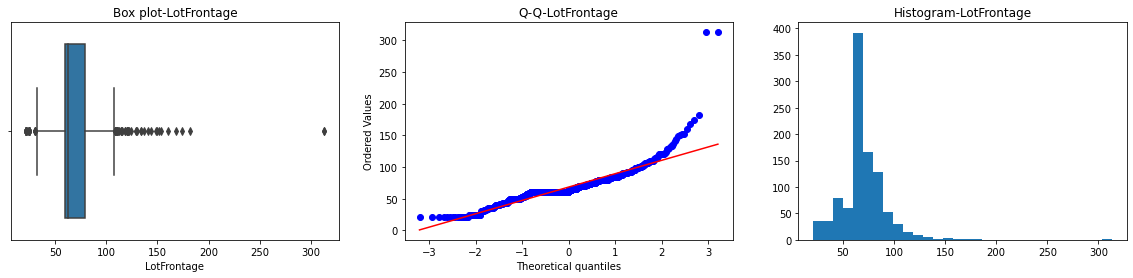

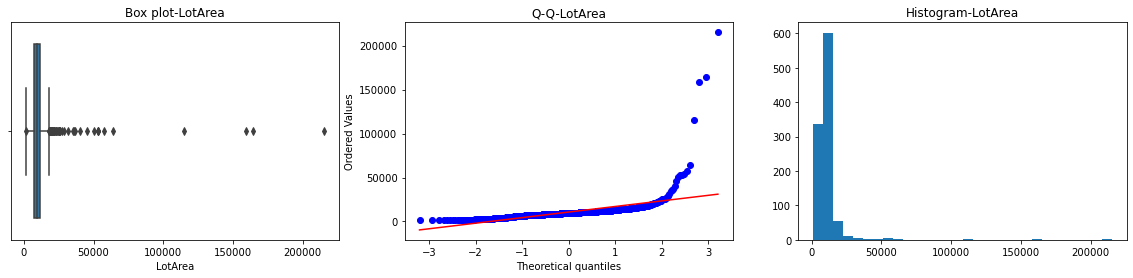

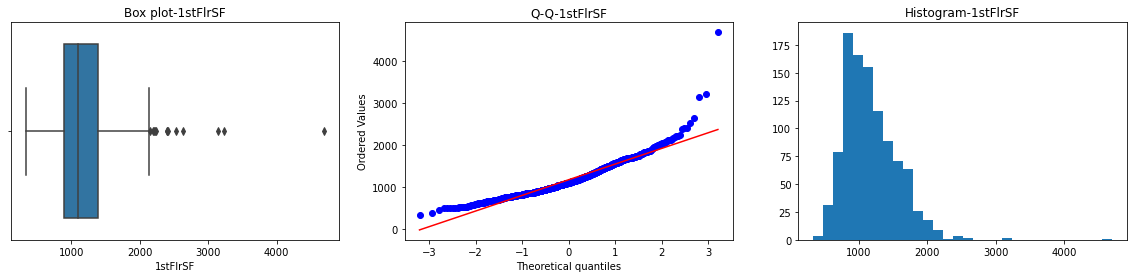

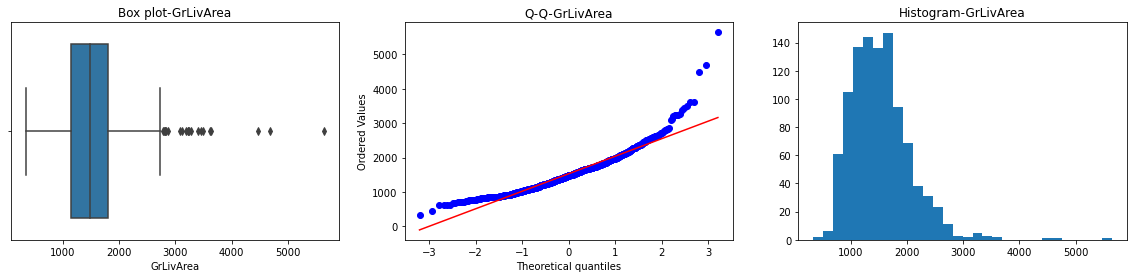

In [19]:
for var in cont_var:
    diagnostic(X_train, var)

In [20]:
#Capping the outliers

def quantile_boundary(df, var, lower_bound, upper_bound):
    
    """
    This function caps the oulier using lower and upper bound 
    decided by use
    """
    
    lower = df[var].quantile(lower_bound)
    upper = df[var].quantile(upper_bound)
    
    return lower, upper

In [21]:
#applying the above function to cap the variables
lower,upper = quantile_boundary(X_train, "LotFrontage",0.065,0.95)
X_train["LotFrontage"] = np.where(X_train["LotFrontage"]<lower,lower,
                           np.where(X_train["LotFrontage"]>upper,upper,X_train["LotFrontage"]))

#applying the above function to cap the variables
lower,upper = quantile_boundary(X_train, "LotArea",0.0065,0.955)
X_train["LotArea"] = np.where(X_train["LotArea"]<lower,lower,
                           np.where(X_train["LotArea"]>upper,upper,X_train["LotArea"]))

#applying the above function to cap the variables
lower,upper = quantile_boundary(X_train, "1stFlrSF",0.0065,0.985)
X_train["1stFlrSF"] = np.where(X_train["1stFlrSF"]<lower,lower,
                           np.where(X_train["1stFlrSF"]>upper,upper,X_train["1stFlrSF"]))

#applying the above function to cap the variables
lower,upper = quantile_boundary(X_train, "GrLivArea",0.0065,0.98)
X_train["GrLivArea"] = np.where(X_train["GrLivArea"]<lower,lower,
                           np.where(X_train["GrLivArea"]>upper,upper,X_train["GrLivArea"]))



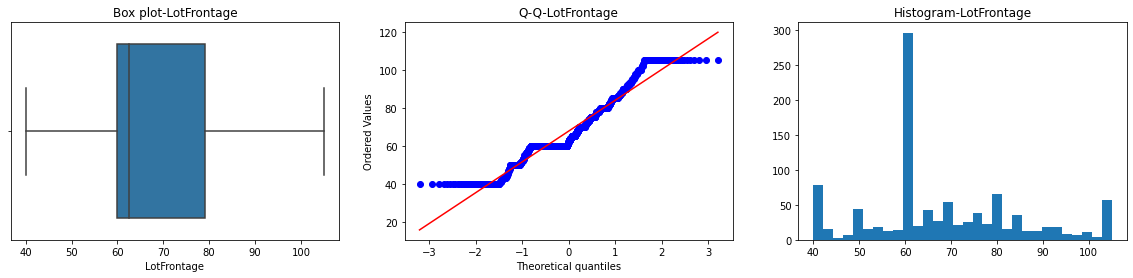

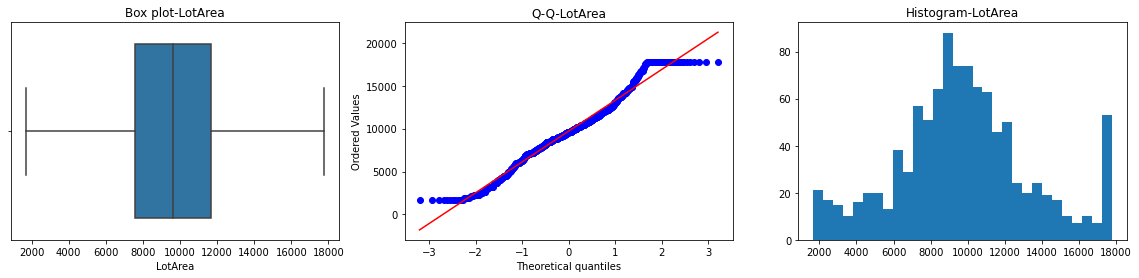

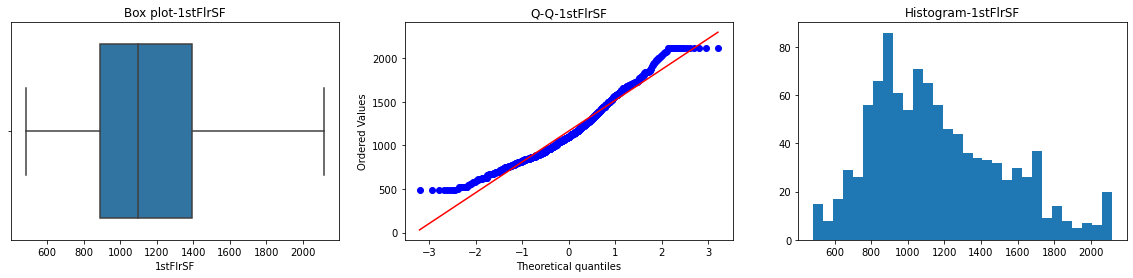

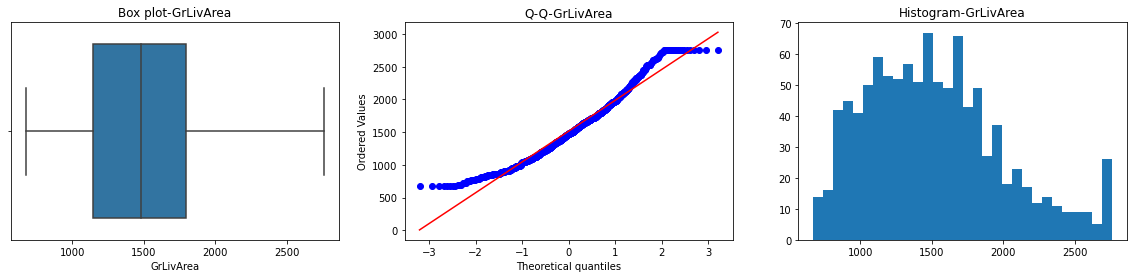

In [22]:
#plotting it again to check whether there are ouliers are not 
for var in cont_var:
    diagnostic(X_train, var)

In [23]:
#X_train["SalePrice"]=X_train["SalePrice"]**(1/2)
X_train["SalePrice"]=np.log(X_train["SalePrice"])

# Time Variable

In [24]:
# writing a function which will convert years into age

def year_to_age(df, var):
    """
    this function takes in year and return the age for that particular varaible
    """
    
    df[var] = df["YrSold"]-df[var]
    
    return df

In [25]:
#applying to all the year column
year_var = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
for var in year_var:
    
    X_train = year_to_age(X_train, var)
    X_test = year_to_age(X_test, var)
    test = year_to_age(test, var)


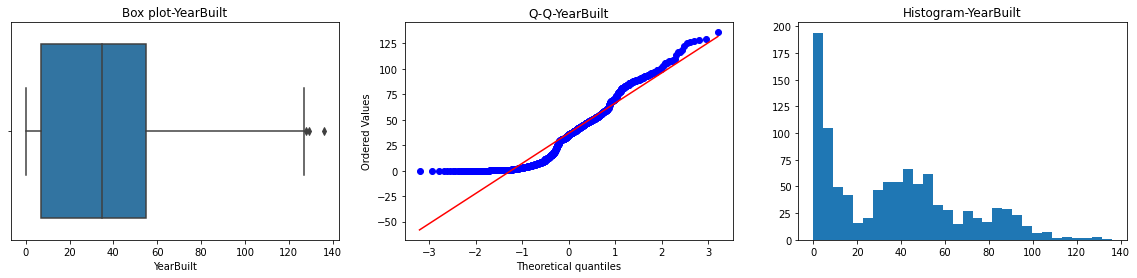

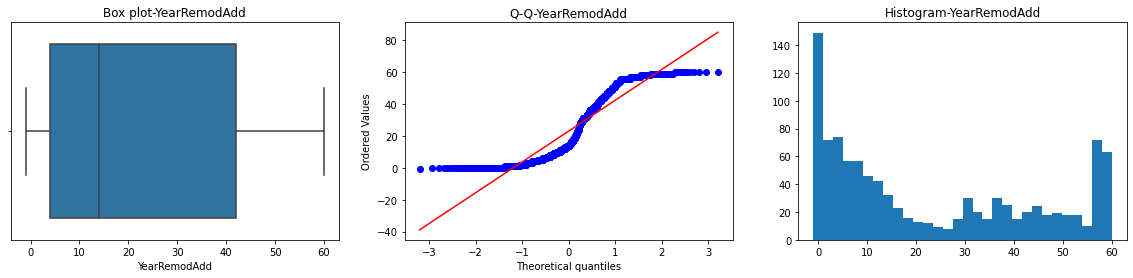

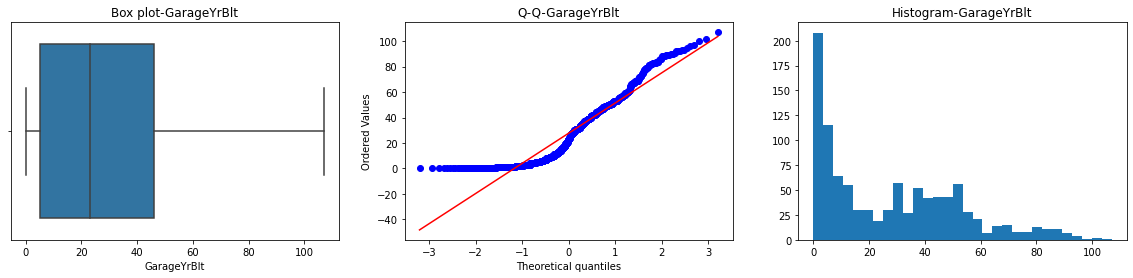

In [26]:
for var in year_var:
    diagnostic(X_train, var)

In [27]:
lower,upper = quantile_boundary(X_train, "YearBuilt",0.065,0.97)
X_train["YearBuilt"] = np.where(X_train["YearBuilt"]<lower,lower,
                           np.where(X_train["YearBuilt"]>upper,upper,X_train["YearBuilt"]))


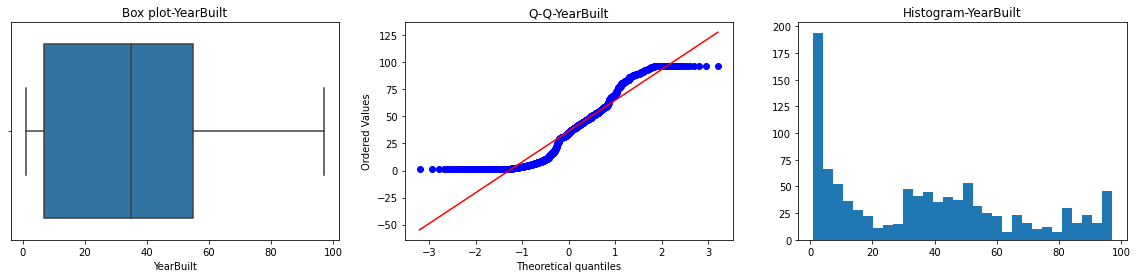

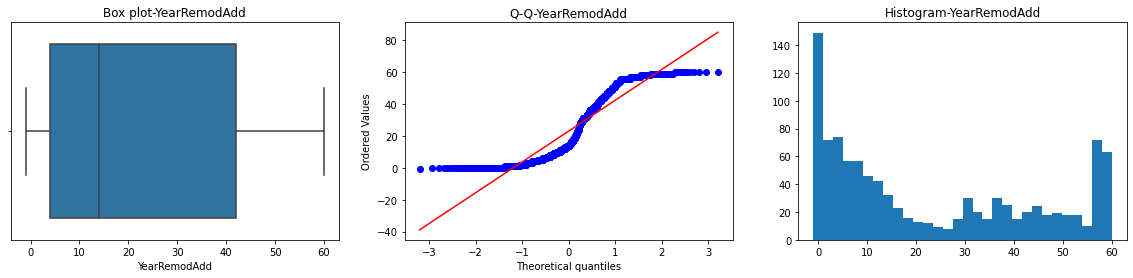

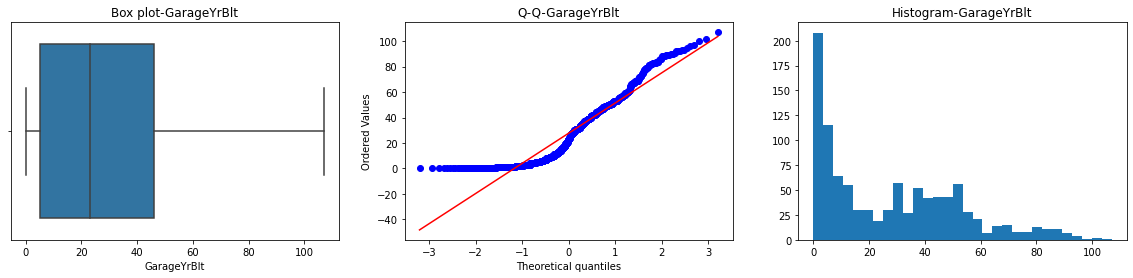

In [28]:
for var in year_var:
    diagnostic(X_train, var)

# Feature Scaling

In [29]:
# capture all variables in a list
# except the target and the ID

feature_scale = [var for var in X_train.columns if var not in ['Id', 'SalePrice']]

# count number of variables
len(feature_scale)

82

In [30]:
#filling the remaining missing values with mode
for var in feature_scale:
    mode_val = X_train[var].mode()[0]
    test[var] = test[var].fillna(mode_val)

In [31]:
#using min max scaler to scale the features
scaler=MinMaxScaler()

X_train[feature_scale] = scaler.fit_transform(X_train[feature_scale])
X_test[feature_scale] = scaler.transform(X_test[feature_scale])
test[feature_scale] = scaler.transform(test[feature_scale])

# Feature Selection

In [32]:
# capture the target
y_train = X_train['SalePrice'].values
y_test = X_test['SalePrice'].values

# drop unnecessary variables from our training and testing sets
X_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
X_test.drop(['Id', 'SalePrice'], axis=1, inplace=True)

In [33]:
#using lasso to select the best feature for the data
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel


sfm = SelectFromModel(Lasso(alpha = 0.001, random_state = 0))
sfm.fit(X_train,y_train)
feature_selected = X_train.columns[(sfm.get_support())]
len(feature_selected)

42

In [34]:
#keeping only selected features
X_train=X_train[feature_selected]
X_test = X_test[feature_selected]
test = test[feature_selected]

In [35]:
#creating cross validation rmse
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 14))
    return(rmse)

In [36]:
#fitting Ridge Regression
model_ridge = Ridge()

alphas = [0.08,0.05, 0.1,0.001, 0.3, 1, 3, 5, 10,11, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.min()

0.12820625869743668

In [37]:
#fitting lasso regression
model_lasso = LassoCV(alphas = [0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]).fit(X_train, y_train)
rmse_cv(model_lasso).min()

0.09829384038781824

In [38]:
#fitting Xgboost
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=450, max_depth=3, learning_rate=0.06) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.06, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=450, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
rmse_cv(model_xgb).min()

0.08817595521141174

In [40]:
#making predictions on test set

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

linear_preds = 0.4*xgb_preds+0.6*lasso_preds 

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds,"actual":y_test, 
                            "linear_preds": linear_preds })

predictions["Xgb_error"]=predictions["actual"]-predictions["xgb"]
predictions["Lasso_error"]=predictions["actual"]-predictions["lasso"]
predictions["Linear_error"]=predictions["linear_preds"]-predictions["lasso"]

Text(0.5, 1.0, 'Xg_boost V/s Lasso')

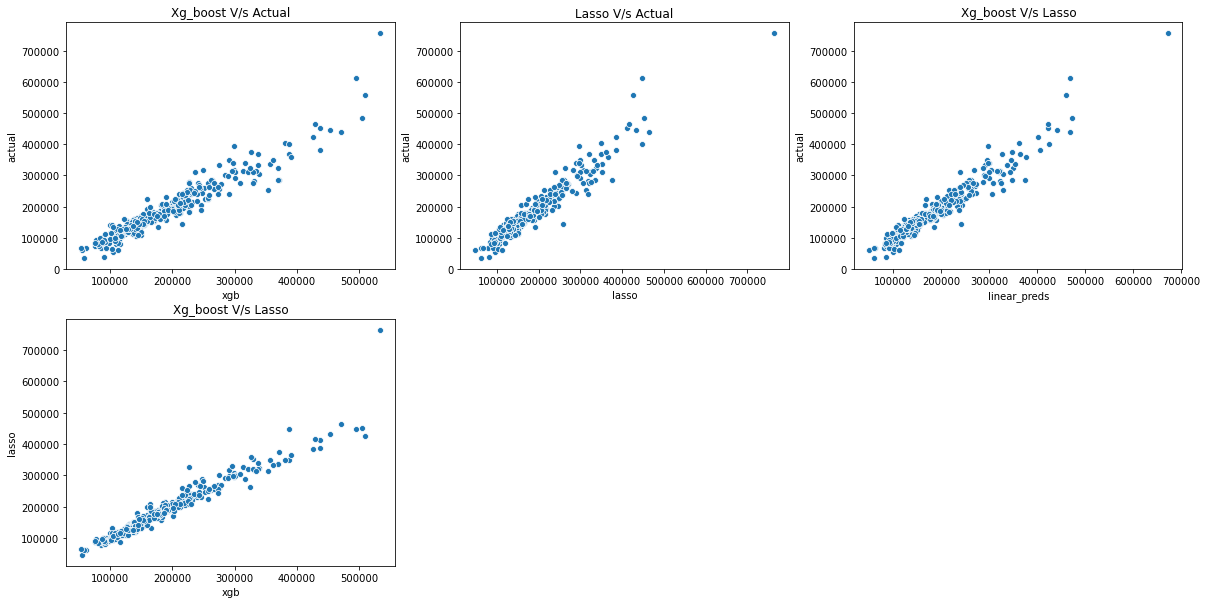

In [41]:
#prediction plots

plt.figure(figsize=(20,10))
    
plt.subplot(2, 3, 1)
sns.scatterplot(x="xgb",y="actual", data=predictions)
plt.title("Xg_boost V/s Actual")
    
plt.subplot(2, 3, 2)
sns.scatterplot(x="lasso",y="actual", data=predictions)
plt.title("Lasso V/s Actual")
       
plt.subplot(2, 3, 3)
sns.scatterplot(x="linear_preds",y="actual", data=predictions)
plt.title("Xg_boost V/s Lasso")




plt.subplot(2, 3, 4)
sns.scatterplot(x="xgb",y="lasso", data=predictions)
plt.title("Xg_boost V/s Lasso")


In [42]:
from sklearn.metrics import r2_score, mean_squared_error
#printing score
print(mean_squared_error(y_test,predictions["linear_preds"])**(1/2))
print(r2_score(y_test,predictions["linear_preds"]))

21554.812350443088
0.9334187886577962


In [43]:
#test predictions
test_prediction= 0.4*np.expm1(model_xgb.predict(test)) + 0.6*np.expm1(model_lasso.predict(test))

In [44]:
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": test_prediction
    })
submission.to_csv('submission.csv', index=False)